*Суммарное время выполнения блокнота на GPU ~ 10 мин.

# Задание 1. Hooks для анализа активаций слоев

Требуется разобраться с механизмом hooks в PyTorch



Загрузка датасета MNIST

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]
)

mnist = datasets.MNIST("MNIST", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST("MNIST", train=False, download=True, transform=transform)

train_set, val_set, _ = random_split(mnist, [16000, 4000, 40000])

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 94402072.71it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88162804.82it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65527386.22it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21772032.88it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Фиксируем seed для воспроизводимости результатов.

In [ ]:
import random
import torch
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

В качестве модели используйте LeNet.

In [ ]:
import torch
import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):  # input [batch, 1, 28, 28]
        x = self.activation(self.pool(self.conv1(x)))
        x = self.activation(self.pool(self.conv2(x)))
        x = self.activation(self.fc1(x.flatten(start_dim=1)))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet()
model

LeNet(
  (activation): ReLU()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Задание

Добавьте код для отображения гистограмм активаций для всех слоев в одних осях.

Можно использовать любой из инструментов: [Matplotlib](https://matplotlib.org/), [Tensorboard](https://pytorch.org/docs/stable/tensorboard.html), [W&B](https://wandb.ai/site)  

Для визуализации подайте на вход модели шум, сэмплированный из нормального распределения.

Совет: при генерации шума обратите внимание на то, что сверточные слои ожидают на вход четырехмерный тензор.

In [ ]:
from collections import defaultdict
import torch.optim as optim

def get_forward_hook(history_dict, key):
    def forward_hook(self, input_, output):
        history_dict[key] = input_[0].cpu().detach().numpy().flatten()
    return forward_hook

def register_model_hooks(model):
    hooks_data_history = defaultdict(list)

    forward_hook = get_forward_hook(hooks_data_history, f"ReLU_conv2")
    model.conv2.register_forward_hook(forward_hook)

    #backward_hook = get_backward_hook(hooks_data_history, f"ReLU_conv2")
    #model.conv2.register_backward_hook(backward_hook)


    forward_hook = get_forward_hook(hooks_data_history, f"ReLU_fc1")
    model.fc1.register_forward_hook(forward_hook)

    forward_hook = get_forward_hook(hooks_data_history, f"ReLU_fc2")
    model.fc2.register_forward_hook(forward_hook)

    forward_hook = get_forward_hook(hooks_data_history, f"ReLU_fc3")
    model.fc3.register_forward_hook(forward_hook)
    return hooks_data_history


In [ ]:
noise = torch.Tensor(np.ones((1, 1, 28, 28)))
hooks_data_history = register_model_hooks(model)
output = model(noise)
hooks_data_history

defaultdict(list,
            {'ReLU_conv2': array([0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 , 0.925952 ,
                    0.

In [ ]:
print(*model.children())

ReLU() Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) Linear(in_features=256, out_features=120, bias=True) Linear(in_features=120, out_features=84, bias=True) Linear(in_features=84, out_features=10, bias=True)


In [ ]:
import matplotlib.pyplot as plt

def plot_hooks_data(hooks_data_history):
    keys = hooks_data_history.keys()
    n_layers = len(keys) // 2

    activation_names = ["ReLU_conv2", "ReLU_fc1", "ReLU_fc2", "ReLU_fc3"]
    activations_on_layers = [
        hooks_data_history[activation] for activation in activation_names
    ]


    for plot_name, values, labels in zip(
        ["activations"],
        [activations_on_layers],
        [activation_names],
    ):
        plt.hist(activations_on_layers)
        plt.legend(activation_names)
        plt.show()

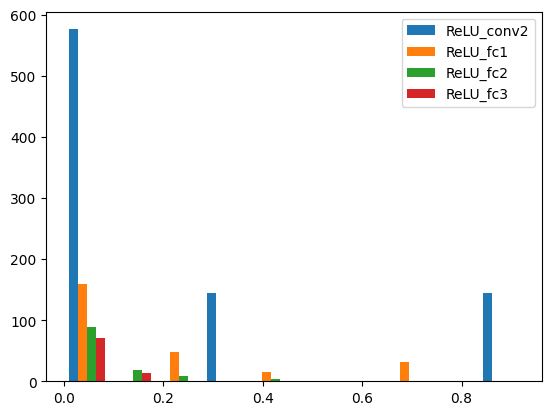

In [ ]:
plot_hooks_data(hooks_data_history)

## Формат результата

* Гистограмма модулей активаций для каждого слоя

Пример графика:





<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_1_ex07_v1_fix.png" width="500">

# Задание 2. Переобучение нейронной сети

Иногда задачу, которая выглядит как задача классификации, лучше решать как задачу регрессии. Это происходит в случае, когда метки классов имеют естественный порядок: например, при диагностике рака намного адекватнее получить результат между 2-й и 3-й стадией, чем между отсутствием и 4-й.

До этого мы всегда боролись с переобучением. В этом задании нужно наоборот, полностью переобучить сеть. Задача регрессии, 16 объектов с 20 признаками (сгенерированы случайно).

Не допускается менять тип задачи с регрессии на классификацию (менять criterion или количество выходов), а также использовать условный оператор или округлять значения. Можно использовать пред и пост обработку данных (без переходов к булевой алгебре и изменений типов данных), менять  архитектуру сети, увеличивать количество эпох, менять алгоритм оптимизации.

In [ ]:
# нужно переобучить (нормализация)

In [ ]:
import random
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

np.random.seed(42)
data = np.random.randint(0, 504, size=(16, 20))
label = np.random.choice([0, 10, 20, 30, 40], 16).reshape(16, 1)


class CustomImageDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label_idx = torch.tensor(self.label[idx])
        data_idx = torch.tensor(self.data[idx])

        return data_idx.to(torch.float32), label_idx.to(torch.float32)


train_data = CustomImageDataset(data, label)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

Архитектура сети

In [ ]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(20, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 1)  # don't change out size

        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

Модель, функция ошибок, оптимизатор

In [ ]:
model = Net()
criterion = nn.MSELoss()  # don't change
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Код для обучения

In [ ]:
from tqdm.notebook import trange

num_epochs = 10000
loss_hist = []
epochs = trange(num_epochs)
for epoch in epochs:
    hist_loss = 0
    for i, batch in enumerate(train_dataloader, 0):
        data, labels = batch
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        hist_loss += loss.item()

    loss_hist.append(hist_loss / len(train_dataloader))
    epochs.set_description(f"Epoch={epoch}  loss={loss_hist[epoch]:.4}")

pred = model(data)
for i in range(16):
    print(f"Prediction: {pred[i].item()} \t True: {labels[i].item()}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Prediction: 20.000070571899414 	 True: 20.0
Prediction: 20.00004005432129 	 True: 20.0
Prediction: 20.000064849853516 	 True: 20.0
Prediction: 30.00006866455078 	 True: 30.0
Prediction: 30.000043869018555 	 True: 30.0
Prediction: 30.000064849853516 	 True: 30.0
Prediction: 20.00006103515625 	 True: 20.0
Prediction: 10.000038146972656 	 True: 10.0
Prediction: 2.9981136322021484e-05 	 True: 0.0
Prediction: 20.00005340576172 	 True: 20.0
Prediction: 20.000045776367188 	 True: 20.0
Prediction: 30.00006103515625 	 True: 30.0
Prediction: 3.5822391510009766e-05 	 True: 0.0
Prediction: 30.000064849853516 	 True: 30.0
Prediction: 40.000022888183594 	 True: 40.0
Prediction: 30.000057220458984 	 True: 30.0


**Вывод: увеличение количества эпох на несколько порядков ведет к переобучению модели**

## Формат результата


Переобученная сеть, которая дает точный результат на каждом объекте.

Например:

```
Prediction: 10.0 	 True: 10.0
Prediction: 20.0 	 True: 20.0
Prediction: 30.0 	 True: 30.0
Prediction: 30.0 	 True: 30.0
Prediction: 20.0 	 True: 20.0
Prediction: 0.0 	  True: 0.0

```



# Задание 3. Сравнение оптимизаторов

В этом задании вам нужно будет обучить модель из прошлого задания двумя способами:
- с оптимизатором с моментом,
- с адаптивным оптимизатором.

Постройте графики Loss и accuracy. Сравните качество и скорость обучения.

Посчитайте итоговое значение accuracy на mnist_test.

In [ ]:
import torch.optim as optim
import torch

In [ ]:
# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch

def get_correct_count(pred, labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode()
def calculate_accuracy(model, data_loader, criterion, device):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs.to(device))
        loss += criterion(pred, labels.to(device))
        correct += get_correct_count(pred, labels.to(device))
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [ ]:
def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

In [ ]:
from tqdm.notebook import tqdm


def train_model(model, optimizer, model_name=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []
    train_history["accuracy"] = []

    for epoch in tqdm(range(num_epochs)):
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        accuracy, loss_val = calculate_accuracy(model, val_loader, criterion, device)
        train_history["accuracy"].append(accuracy)
    return train_history

## Оптимизатор с моментом

In [ ]:
# Your code here
model1 = LeNet().to(device)
optimizer1 = optim.SGD(model1.parameters(), momentum=0.9, lr=0.001)
model_name = "SGD_momentum"
SGD_model = train_model(model1, optimizer1, model_name="SGD_momentum")

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
type(SGD_model)

dict

## Адаптивный оптимизатор

In [ ]:
model2 = LeNet().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-2)
model_name = "Adam"
Adam_model = train_model(model2, optimizer2, model_name="Adam")

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
type(Adam_model)

dict

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    """
    Groups contain a list of variables to output, like ["loss", "accuracy"]
    If group is None all variables will be plotted

    Title is expariment_id like "Relu_Adam_lr003"
    All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [ ]:
len(SGD_model['loss_on_train'])

315

In [ ]:
SGD_model['accuracy']

[0.1635, 0.2075, 0.34075, 0.56475, 0.70525]

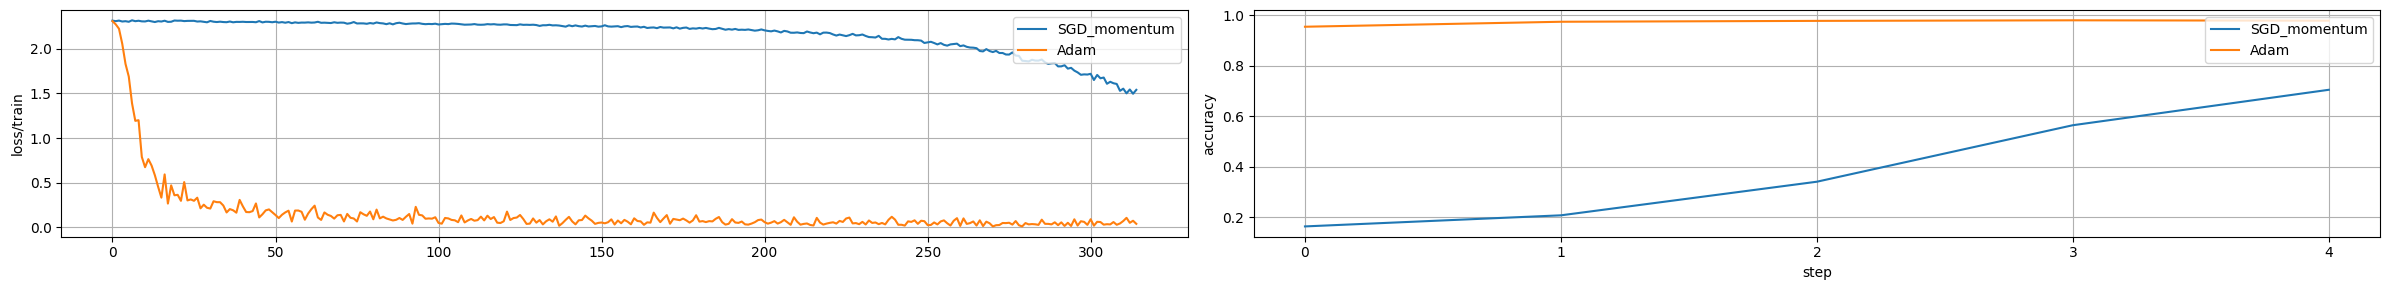

In [ ]:
pplotter = ProgressPlotter()
pplotter.set_title('SGD_momentum')
for i in range(len(SGD_model['loss_on_train'])):
    pplotter.add_scalar('loss/train', SGD_model['loss_on_train'][i])
for i in range(len(SGD_model['accuracy'])):
    pplotter.add_scalar('accuracy', SGD_model['accuracy'][i])
pplotter.set_title('Adam')
for i in range(len(Adam_model['loss_on_train'])):
    pplotter.add_scalar('loss/train', Adam_model['loss_on_train'][i])
for i in range(len(Adam_model['accuracy'])):
    pplotter.add_scalar('accuracy', Adam_model['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

In [ ]:
print('Accuracy, loss for SGD_momentum')
calculate_accuracy(model1, test_loader, nn.CrossEntropyLoss().to(device), device)

Accuracy, loss for SGD_momentum


(0.7099, 1.4760237693786622)

In [ ]:
print('Accuracy, loss for Adam')
calculate_accuracy(model2, test_loader, nn.CrossEntropyLoss().to(device), device)

Accuracy, loss for Adam


(0.9808, 0.06174294352531433)

**Напишите Вывод**:
**Адаптивный оптимизатор оказывается намного лучше оптимизатора с моментом, возможно, потому, что SGD не умеет изменять learning rate**


## Формат результата

* Графики loss-функции и accuracy, пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_3_ex07_v1_fix.png" width="1200" >

* значения accuracy на mnist_test

* вывод

# Задание 4. Dropout

Добавьте в вашу нейросеть Dropout на последних слоях.

Обучите ее на наборе данных MNIST. После этого, сделайте предсказание на тестовом датасете НЕ ДЕЛАЯ `model.eval()`. Повторите процедуру предсказания 20 раз.
Выведите 10 изображений, в классификации которых нейросеть больше всего не уверена (на 20 запусков предсказывала им самые различные классы) и 10 изображений, в классификации которых нейросеть больше всего уверена.

Проверьте себя, указав классы, которые предсказывает модель в состоянии  `model.train()` для выбранных картинок, а также истинные метки классов.


In [ ]:
class LeNet_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):  # input [batch, 1, 28, 28]
        x = self.activation(self.pool(self.conv1(x)))
        x = self.activation(self.pool(self.conv2(x)))
        x = self.activation(self.fc1(x.flatten(start_dim=1)))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
model_dropout = LeNet_dropout().to(device)
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(10):
    running_loss = 0.0
    model_dropout.train()  # Switch to training mode
    for images, labels in train_loader:
        optimizer.zero_grad()
        predicted_labels = model_dropout(images.to(device))
        loss = criterion(predicted_labels, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')

Epoch 1, Loss: 1.543
Epoch 2, Loss: 0.580
Epoch 3, Loss: 0.360
Epoch 4, Loss: 0.279
Epoch 5, Loss: 0.232
Epoch 6, Loss: 0.201
Epoch 7, Loss: 0.181
Epoch 8, Loss: 0.160
Epoch 9, Loss: 0.149
Epoch 10, Loss: 0.135


In [ ]:
# get batch
imgs, labels = next(iter(test_loader))
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([256, 1, 28, 28])


In [ ]:
prediction_results = []
with torch.no_grad():
    for _ in range(20):
        predictions = model_dropout(imgs.to(device))
        prediction_results.append(predictions)

In [ ]:
prob = []
for i in range(20):
  prob.append(nn.Softmax(dim=0)(prediction_results[i].detach()))

In [ ]:
prob[0]

tensor([[1.6530e-10, 2.7916e-10, 6.7668e-10,  ..., 3.7101e-05, 3.0250e-09,
         1.4633e-11],
        [5.5350e-10, 7.3377e-12, 7.7301e-04,  ..., 1.7725e-09, 1.9448e-08,
         1.2983e-15],
        [2.0097e-18, 9.9805e-01, 3.7764e-10,  ..., 2.9204e-11, 5.1927e-09,
         2.5988e-12],
        ...,
        [5.8070e-11, 4.6215e-12, 8.4613e-11,  ..., 7.7462e-13, 1.7783e-06,
         8.1942e-10],
        [2.3051e-15, 5.1546e-11, 3.6493e-09,  ..., 2.8082e-05, 1.4099e-09,
         5.9807e-09],
        [7.4032e-15, 8.3095e-09, 1.3591e-07,  ..., 1.5523e-05, 2.7543e-09,
         2.5271e-09]], device='cuda:0')

In [ ]:
# remove axis
imgs = torch.reshape(imgs, (256, 28, 28))
print("imgs shape(after reshape): ", imgs.shape)

imgs shape(after reshape):  torch.Size([256, 28, 28])


In [ ]:
imgs = imgs[:10]
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([10, 28, 28])


In [ ]:
import numpy as np

pred = pred[:10].detach()
print("Prediction(1 sample):\n", pred[0])
digits = np.argmax(pred.cpu().numpy(), axis=1)
print("Predicted class: ", digits[0])

Prediction(1 sample):
 tensor([ -6.3716, -17.8184,   2.3417,  -1.5831, -17.0128,  -6.6724, -31.8841,
         29.3408, -18.4821,   7.1308], device='cuda:0')
Predicted class:  7


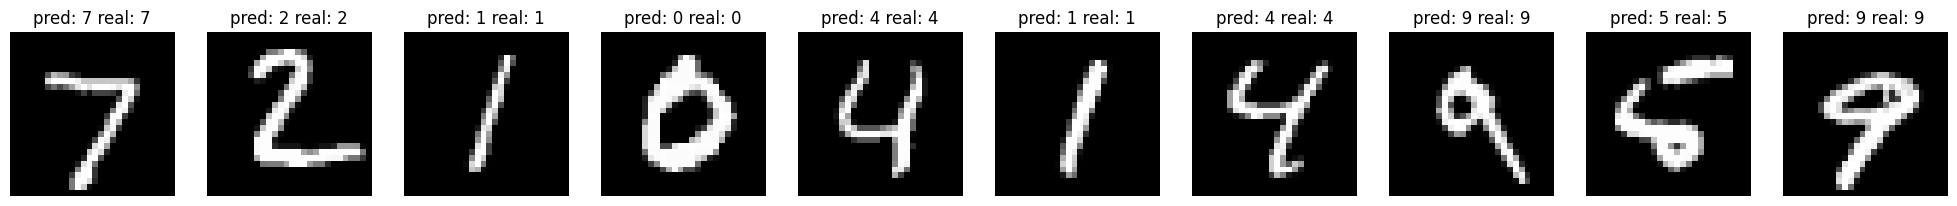

In [ ]:
plt.figure(figsize=(25.0, 25.0))
for i in range(10):
    img = imgs[i]

    plt.subplot(1, 10, i + 1)
    plt.title(
        "pred: " + str(digits[i]) + " real: " + str(labels[i].numpy())
    )  # predicted and real values
    plt.axis("off")
    plt.imshow(img.numpy(), cmap="gray")

In [ ]:
with torch.no_grad():
    all_predicted_labels = model_dropout(torch.cat([images.to(device) for images, _ in train_loader]))

In [ ]:
all_predicted_labels

tensor([[ -3.6515,  -0.2670,   4.3890,  ...,  -2.2980,  -2.9763,  -4.9288],
        [  0.5435,  -2.5858,   0.4718,  ..., -11.2909,   1.5965,  -7.7528],
        [  6.1110,  -2.5034,   1.7519,  ...,   0.7783,  -0.7120,  -2.8054],
        ...,
        [ -5.5060,  -3.3701,   1.5815,  ...,  -4.2532,  -1.2668,   1.1876],
        [ -4.0110,  -1.2982,  -1.2134,  ...,  -6.6133,  -3.7210,   0.9123],
        [ -5.8291,  14.3028,   1.6354,  ...,   0.1313,  -1.5893,  -7.9845]],
       device='cuda:0')

In [ ]:
_, predicted = torch.max(all_predicted_labels, 1)
losses = torch.abs(predicted - torch.cat([labels.to(device) for _, labels in train_loader]))
sorted_indices = torch.argsort(losses)

In [ ]:
predicted

tensor([2, 6, 0,  ..., 4, 4, 1], device='cuda:0')

In [ ]:
losses

tensor([2, 1, 8,  ..., 2, 3, 3], device='cuda:0')

In [ ]:
sorted_indices

tensor([   10,    16,    19,  ..., 15910, 15956, 15960], device='cuda:0')

In [ ]:
most_learnable_indices = sorted_indices[:10]
least_learnable_indices = sorted_indices[-10:]

most_learnable_images = torch.cat([images.to(device) for images, _ in train_loader])[most_learnable_indices]
least_learnable_images = torch.cat([images.to(device) for images, _ in train_loader])[least_learnable_indices]

In [ ]:
import matplotlib.pyplot as plt

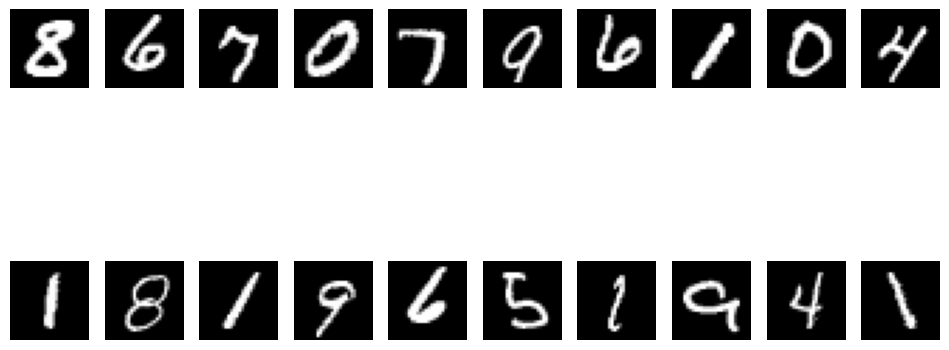

In [ ]:
plt.figure(figsize=(12, 6))

for i, (most_image, least_image) in enumerate(zip(most_learnable_images, least_learnable_images)):
    ax = plt.subplot(2, 10, i + 1)
    ax.imshow(most_image.cpu()[0], cmap=plt.cm.gray)
    ax.axis('off')

    ax = plt.subplot(2, 10, i + 11)
    ax.imshow(least_image.cpu()[0], cmap=plt.cm.gray)
    ax.axis('off')

plt.show()

## Формат результата

* Изображения

Изображения, в которых модель уверена больше всего:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_4_ex07_v1.png" width="1200" >


Изображения, в которых модель не уверена больше всего:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_2_task_4_ex07_v1_fix.png" width="1200" >

* Метки классов, которые предсказывает модель в состоянии  `model.train()` для выбранных картинок, а также истинные метки классов.

*Необязательно у вас должны получиться эти же самые картинки.

# Задание 6*. Влияние инициализации весов

Изучите влияние инициализации весов на скорость и качество обучения. Требуется поставить 4 эксперимента.

*Если вы решите возспользоваться matplotlib для вывода графиков, можете использовать код из ячейки ниже.*





In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    """
    Groups contain a list of variables to output, like ["loss", "accuracy"]
    If group is None all variables will be plotted

    Title is expariment_id like "Relu_Adam_lr003"
    All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Пример работы кода для визуализации:

In [ ]:
pp = ProgressPlotter(title="model1")
for i in range(1, 5):
    pp.add_scalar("Loss", i + 1)
    pp.add_scalar("acc", (i + 1) ** 2)
pp.set_title("model2")
for i in range(1, 5):
    pp.add_scalar("Loss", 2 * i - 1)
    pp.add_scalar("acc", (2 * i - 1) ** 2)
pp.display(["Loss", "acc"])

Совет: в данном задании используйте lr = 0.03 и 5-6 эпох.

Код для обучения модели. Добавьте код для подсчета accuracy, можно использовать код из прошлых заданий.

In [ ]:
import torch
import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):  # input [batch, 1, 28, 28]
        x = self.activation(self.pool(self.conv1(x)))
        x = self.activation(self.pool(self.conv2(x)))
        x = self.activation(self.fc1(x.flatten(start_dim=1)))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch

def get_correct_count(pred, labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode()
def calculate_accuracy(model, data_loader, criterion, device):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs.to(device))
        loss += criterion(pred, labels.to(device))
        correct += get_correct_count(pred, labels.to(device))
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [ ]:
def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

In [ ]:
from tqdm.notebook import tqdm


def train_model(model, optimizer, model_name=None, num_epochs=6):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []
    train_history["accuracy"] = []

    for epoch in tqdm(range(num_epochs)):
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        accuracy, loss_val = calculate_accuracy(model, val_loader, criterion, device)
        train_history["accuracy"].append(accuracy)
    return train_history

## ReLU +  инициализация по умолчанию
Обучите LeNet на 6-ти эпохах и выведите график Loss. В качестве оптимизатора используйте SGD.

In [ ]:
# Your code here
model_ReLU_base = LeNet().to(device)
optimizer = optim.SGD(model_ReLU_base.parameters(), momentum=0.9, lr=1e-3)
model_ReLU_base_train = train_model(model_ReLU_base, optimizer, model_name="model_ReLU_base")

  0%|          | 0/6 [00:00<?, ?it/s]

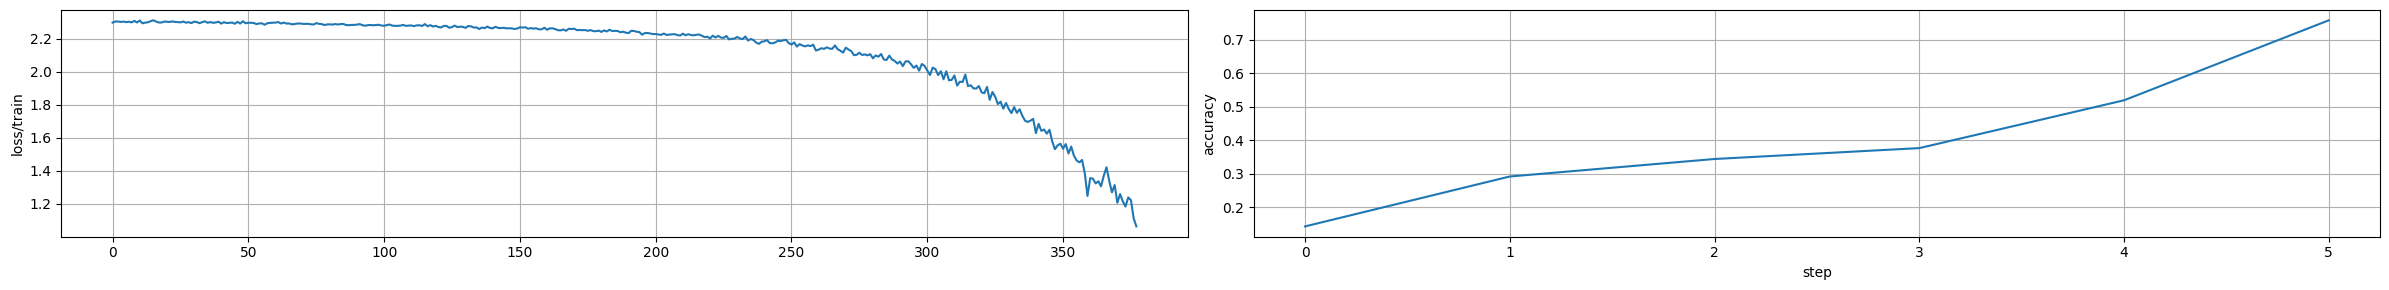

In [ ]:
pplotter = ProgressPlotter()
pplotter.set_title('ReLU_base')
for i in range(len(model_ReLU_base_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_ReLU_base_train['loss_on_train'][i])
for i in range(len(model_ReLU_base_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_ReLU_base_train['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

In [ ]:
model_ReLU_base_train['accuracy']

[0.143, 0.292, 0.34425, 0.37675, 0.5195, 0.75825]

## Tanh
Замените функцию активации на `nn.Tanh`. Выведите график loss в тех же осях.

In [ ]:
# Your code here
model_Tanh = LeNet().to(device)
model_Tanh.activation = torch.nn.Tanh()
model_Tanh

LeNet(
  (activation): Tanh()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
model_Tanh = LeNet().to(device)
optimizer = optim.SGD(model_Tanh.parameters(), momentum=0.9, lr=1e-3)
model_Tanh_train = train_model(model_Tanh, optimizer, model_name="model_Tanh")

  0%|          | 0/6 [00:00<?, ?it/s]

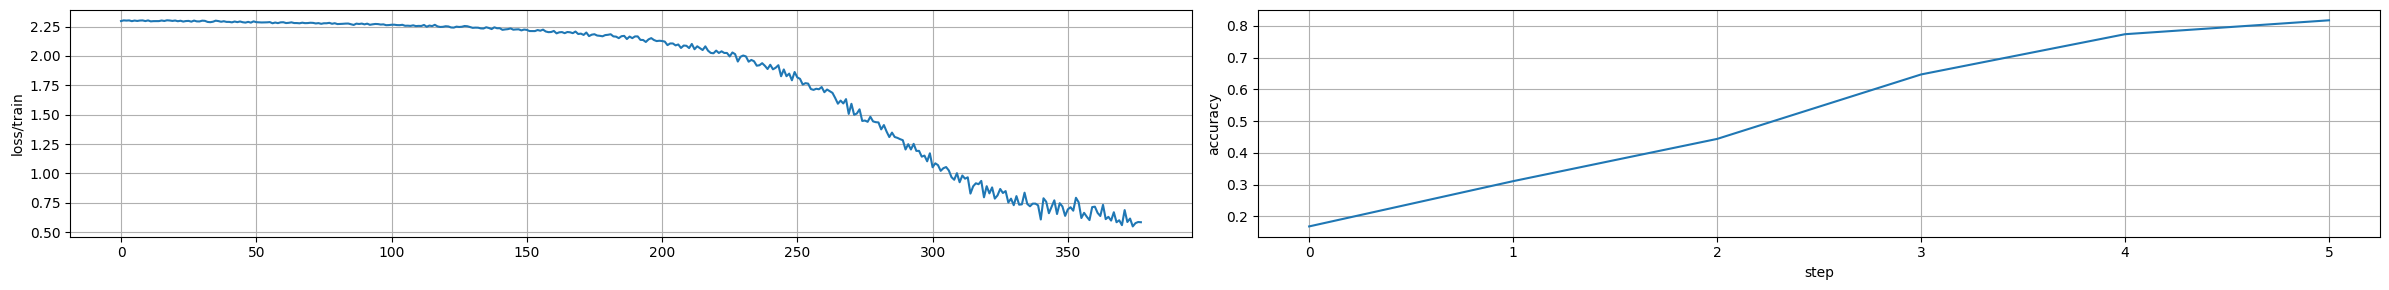

In [ ]:
pplotter = ProgressPlotter()
pplotter.set_title('Tanh')
for i in range(len(model_Tanh_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_Tanh_train['loss_on_train'][i])
for i in range(len(model_Tanh_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_Tanh_train['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

## Tanh + Xavier

Инициализируйте веса при помощи алгоритма [Xavier](https://pytorch.org/docs/stable/nn.init.html).
По прежнему используйте `nn.Tanh`. Выведите график Loss в тех же осях.

**Подсказка:** чтобы не менять код класса можете воспользоваться методом [nn.Module.apply](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply)

In [ ]:
# Your code here
def init_weights_xavier(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, gain=torch.nn.init.calculate_gain("tanh"))
model_Tanh_Xavier = LeNet().to(device)
model_Tanh_Xavier.activation = torch.nn.Tanh()
model_Tanh_Xavier.apply(init_weights_xavier)
optimizer = optim.SGD(model_Tanh_Xavier.parameters(), momentum=0.9, lr=1e-3)
model_Tanh_Xavier_train = train_model(model_Tanh_Xavier, optimizer, model_name="model_Tanh_Xavier")

  0%|          | 0/6 [00:00<?, ?it/s]

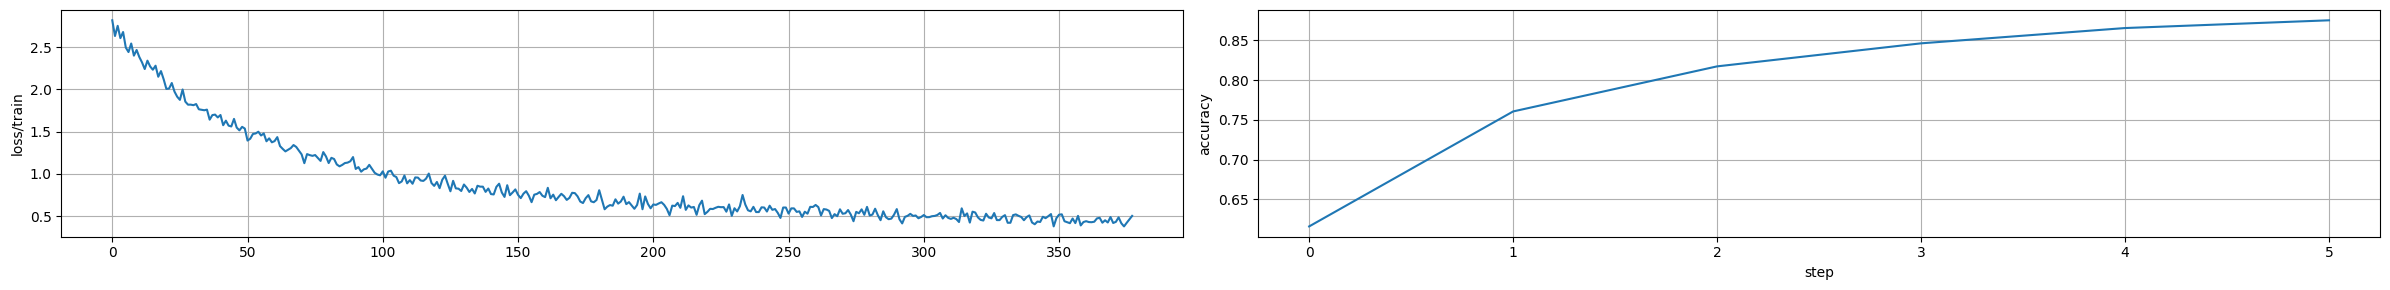

In [ ]:
pplotter = ProgressPlotter()
pplotter.set_title('Tanh_Xavier')
for i in range(len(model_Tanh_Xavier_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_Tanh_Xavier_train['loss_on_train'][i])
for i in range(len(model_Tanh_Xavier_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_Tanh_Xavier_train['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

## ReLU + Kaiming

Теперь замените функцию активации на ReLU и инициализируйте веса при помощи алгоритма [Kaiming](https://pytorch.org/docs/stable/nn.init.html).
Выведите график Loss в тех же осях.


In [ ]:
# Your code here
def init_weights_kaiming(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
model_ReLU_Kaiming = LeNet().to(device)
model_ReLU_Kaiming.activation = torch.nn.ReLU()
model_ReLU_Kaiming.apply(init_weights_kaiming)
optimizer = optim.SGD(model_ReLU_Kaiming.parameters(), momentum=0.9, lr=1e-3)
model_ReLU_Kaiming_train = train_model(model_ReLU_Kaiming, optimizer, model_name="model_ReLU_Kaiming")

  0%|          | 0/6 [00:00<?, ?it/s]

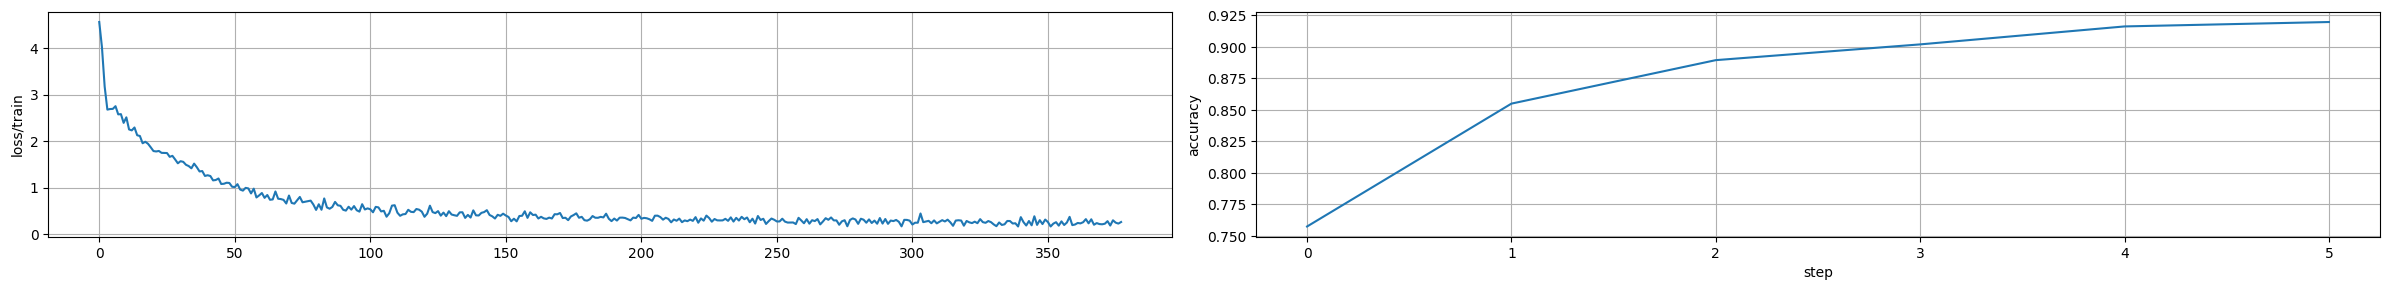

In [ ]:
pplotter = ProgressPlotter()
pplotter.set_title('ReLU_Kaiming')
for i in range(len(model_ReLU_Kaiming_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_ReLU_Kaiming_train['loss_on_train'][i])
for i in range(len(model_ReLU_Kaiming_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_ReLU_Kaiming_train['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

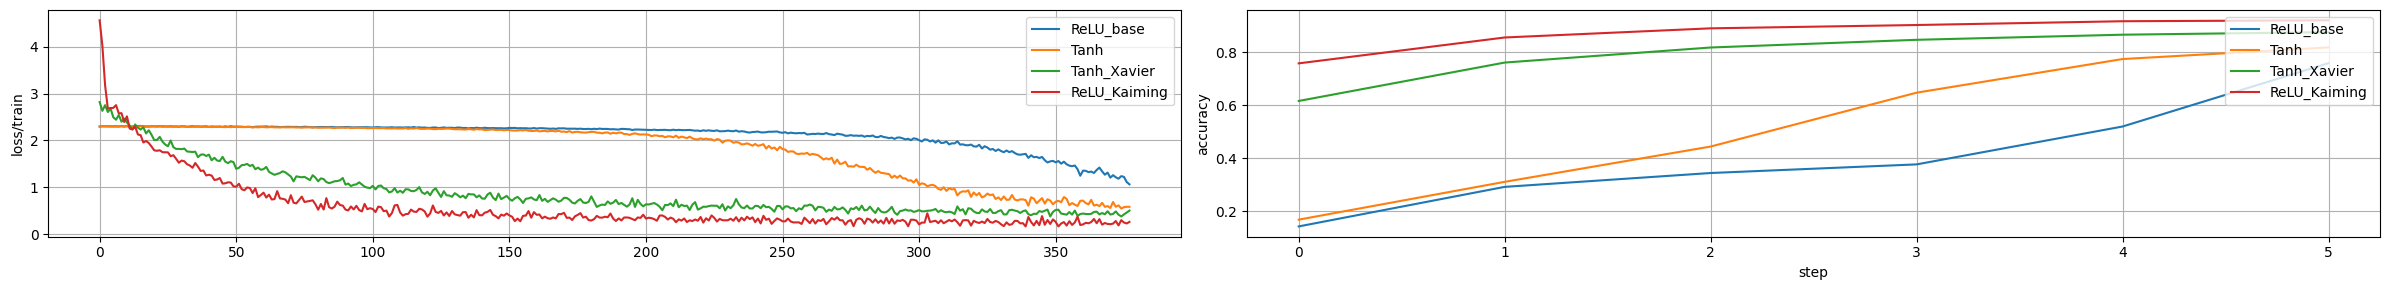

In [ ]:
pplotter = ProgressPlotter()

pplotter.set_title('ReLU_base')
for i in range(len(model_ReLU_base_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_ReLU_base_train['loss_on_train'][i])
for i in range(len(model_ReLU_base_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_ReLU_base_train['accuracy'][i])

pplotter.set_title('Tanh')
for i in range(len(model_Tanh_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_Tanh_train['loss_on_train'][i])
for i in range(len(model_Tanh_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_Tanh_train['accuracy'][i])

pplotter.set_title('Tanh_Xavier')
for i in range(len(model_Tanh_Xavier_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_Tanh_Xavier_train['loss_on_train'][i])
for i in range(len(model_Tanh_Xavier_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_Tanh_Xavier_train['accuracy'][i])

pplotter.set_title('ReLU_Kaiming')
for i in range(len(model_ReLU_Kaiming_train['loss_on_train'])):
    pplotter.add_scalar('loss/train', model_ReLU_Kaiming_train['loss_on_train'][i])
for i in range(len(model_ReLU_Kaiming_train['accuracy'])):
    pplotter.add_scalar('accuracy', model_ReLU_Kaiming_train['accuracy'][i])

pplotter.display(['loss/train', 'accuracy'])

Сравните графики, напишите **выводы**:
Выводы



**Вывод: грамотная инициализация весов позволяет сильно уменьшить значения лосс-функции уже на самых первых эпохах обучения. Модель быстрее сходится. Наиболее эффективным оказалось использование активации ReLU вместе с инициализацией весов Kaiming.**

## Формат результата

* Графики loss для train и accuracy для val. Можно использовать любой из инструментов: Matplotlib, Tensorboard, W&B, ...

Пример графика в matplotlib:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_2_ex07_v1.png" width="1200" >


* Вывод
